# Google Analytics Customer Revenue Prediction

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

Define a function to load the CSV files

In [ ]:
%%time
# credit to https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
def load_df(csv_path='../input/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    json = __import__('json')
    json_normalize = pd.io.json.json_normalize
    df = pd.read_csv(
        csv_path,
        converters={ column: json.loads for column in JSON_COLUMNS },
        dtype={ 'fullVisitorId': 'str', 'visitId': 'str' },
        nrows=nrows
    )
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f'Loaded {csv_path}. Shape: {df.shape}')
    return df

# df_train = load_df()
# df_test = load_df('../input/ga-customer-revenue-prediction/test.csv')

In [ ]:
# %%time
# df_train.to_csv('train-flattened.csv', index=False)
# df_test.to_csv('test-flattened.csv', index=False)

In [3]:
%%time
# these have been saved earlier
df_train = pd.read_csv('../input/ga-store-customer-revenue/train-flattened.csv', dtype={ 'fullVisitorId': str, 'visitId': str, 'trafficSource.campaignCode': str },)
df_test = pd.read_csv('../input/ga-store-customer-revenue/test-flattened.csv', dtype={ 'fullVisitorId': str, 'visitId': str },)

CPU times: user 19.7 s, sys: 1.71 s, total: 21.5 s
Wall time: 21.6 s


## Target variable
`totals.transactionRevenue`
1. There are 903653 records in the train set, 804684 in the test set
2. Only 11515 records resulted in revenue, the remaining 892138 records had zero revenue.
3. Of these, only 9996 visitors (out of 714167 unique visitors) had non-zero revenue. This translates to: only 1.4% of visitors bought something.
4. From 2016-08 to 2017-08, GStore in this dataset had \$1,540,071  in revenue, or \$4,219 per day. With a min spend of \$0.01, max of \$23,129, mean of \$133, and median of \$49

In [4]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype(float)
df_train['totals.transactionRevenue'].notnull().sum()
np.sum(df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum() > 0)
df_train['totals.transactionRevenue'].sum() / 1000000
(df_train['totals.transactionRevenue'][df_train['totals.transactionRevenue'] > 0] / 1000000).agg(['min', 'max', 'mean', 'median'])

min           0.010000
max       23129.500000
mean        133.744789
median       49.450000
Name: totals.transactionRevenue, dtype: float64

## Predictors
1. There are 54 predictos in the train set and 52 in the test set.
2. Predictors not present in the test set can be removed
3. Predictors where values are the same for all records can also be removed

In [5]:
columns = set(df_train.columns).intersection((set(df_test.columns))) # columns present in both train and test
print('Predictors that can be removed:', end=' ')
for i in df_train.columns[df_train.nunique(dropna=False) == 1].tolist() + df_test.columns[df_test.nunique(dropna=False) == 1].tolist():
    if (i in columns):
        print(i, end=', ')
        columns.remove(i)

Predictors that can be removed: socialEngagementType, device.browserSize, device.browserVersion, device.flashVersion, device.language, device.mobileDeviceBranding, device.mobileDeviceInfo, device.mobileDeviceMarketingName, device.mobileDeviceModel, device.mobileInputSelector, device.operatingSystemVersion, device.screenColors, device.screenResolution, geoNetwork.cityId, geoNetwork.latitude, geoNetwork.longitude, geoNetwork.networkLocation, totals.visits, trafficSource.adwordsClickInfo.criteriaParameters, 

In [6]:
def count(var, p=True):
    tmp = pd.concat([
        df_train[var].value_counts(dropna=False),
        df_train[df_train['totals.transactionRevenue'] > 0][var].value_counts(dropna=False),
        df_test[var].value_counts(dropna=False),
    ], keys=['train', 'train with revenue', 'test'], axis=1, sort=False)
    tmp['train %'] = np.round(tmp['train'] / tmp['train'].sum() * 100, 1)
    tmp['train with revenue %'] = np.round(tmp['train with revenue'] / tmp['train with revenue'].sum() * 100, 1)
    tmp['test %'] = np.round(tmp['test'] / tmp['test'].sum() * 100, 1)
    if p: print(tmp.shape)
    return(tmp)

### channelGrouping
- There are 8 unique levels
- The majority is "Organic Search"

In [7]:
count('channelGrouping')

(8, 6)


,train,train with revenue,test,train %,train with revenue %,test %
Organic Search,381561,3438,357402,42.2,29.9,44.4
Social,226117,104,128854,25.0,0.9,16.0
Direct,143026,2042,130108,15.8,17.7,16.2
Referral,104838,5311,106469,11.6,46.1,13.2
Paid Search,25326,468,20301,2.8,4.1,2.5
Affiliates,16403,9,16512,1.8,0.1,2.1
Display,6262,142,45021,0.7,1.2,5.6
(Other),120,1,17,0.0,0.0,0.0


### device

#### browser
- There are 129 of them in both train and test
- The most popular is Chrome (68.7%), followed by Safari, then Firefox.
- Some of them are present only in the train or test set and the counts are very low.

#### device.deviceCategory
- Desktops take up ~ 3 quarters of the train set, but only about 1/3rd in the test set
- Desktops contributed more than 90% of the total revenue

#### device.operatingSystem
- 24 levels in total
- 6 of them: Windows, macintosh, Android, iOS, Linux and Chrome constituted to more than 99% of the market

In [8]:
count('device.browser')
count('device.deviceCategory')
count('device.operatingSystem')

(129, 6)
(3, 6)
(24, 6)


,train,train with revenue,test,train %,train with revenue %,test %
Windows,350072.0,2309.0,269648.0,38.7,20.1,33.5
Macintosh,253938.0,6426.0,184576.0,28.1,55.8,22.9
Android,123892.0,467.0,175494.0,13.7,4.1,21.8
iOS,107665.0,536.0,111669.0,11.9,4.7,13.9
Linux,35034.0,782.0,28937.0,3.9,6.8,3.6
Chrome OS,26337.0,994.0,24981.0,2.9,8.6,3.1
(not set),4695.0,NaN,7120.0,0.5,NaN,0.9
Windows Phone,1216.0,1.0,459.0,0.1,0.0,0.1
Samsung,280.0,NaN,631.0,0.0,NaN,0.1
BlackBerry,218.0,NaN,132.0,0.0,NaN,0.0


### geoNetwork
#### geoNetwork.continent, geoNetwork.subContinent
   - 5 continents + unset
   - 23 subContinents
   - America constituted to nearly half of the traffic and contributed to  more than 95% of the total revenues
   - Europe and Asia had  also nearly half of the traffic, but their combined revenues were 2% of the total revenues

#### geoNetwork.country, geoNetwork.region, geoNetwork.city, geoNetwork.metro
- 228 cities, 483 regions, 956 cities, 123 metros
- US has 40% traffic, but ~95% revenue
- 483 Region: highest traffic came from "not available" (56%), followed by California (12%). But the "not available" only had ~40% revenue, while California had ~29% revenue. Interestingly, New York also had high revenue (13%) relative to its traffic (2.9%).
- 956 citites. The city identified as "not available" has the highest traffic (56%) with ~ 39% revenue. The next in line is Mountain View with 4.5% traffic, but ~11% revenue.
- Similary, metro of "not available" and "not set" have the highest combined traffic (~78%), but only ~42% revenue. Whereas San Francisco-Oakland-San Jose and New York have ~14% traffic but 39% revennue.

#### geoNetwork.networkDomain
- 41982 network domains
- 40%  are "not set" and "unknown", but they contributed to ~61% of the total revenue

In [9]:
count('geoNetwork.continent')
count('geoNetwork.subContinent')
count('geoNetwork.country')
count('geoNetwork.region')
count('geoNetwork.city')
count('geoNetwork.metro')
count('geoNetwork.networkDomain')

(6, 6)
(23, 6)
(228, 6)
(483, 6)
(956, 6)
(123, 6)
(41982, 6)


,train,train with revenue,test,train %,train with revenue %,test %
(not set),244881.0,6645.0,254168.0,27.1,57.7,31.6
unknown.unknown,146034.0,400.0,123762.0,16.2,3.5,15.4
comcast.net,28743.0,934.0,26743.0,3.2,8.1,3.3
rr.com,14827.0,364.0,13888.0,1.6,3.2,1.7
verizon.net,13637.0,469.0,12910.0,1.5,4.1,1.6
ttnet.com.tr,13228.0,1.0,3850.0,1.5,0.0,0.5
comcastbusiness.net,9985.0,294.0,6841.0,1.1,2.6,0.9
hinet.net,7919.0,11.0,8014.0,0.9,0.1,1.0
virginm.net,6414.0,1.0,6180.0,0.7,0.0,0.8
3bb.co.th,6046.0,1.0,1786.0,0.7,0.0,0.2


### trafficSource
- 77 trafficSource.adContent. Most of them are NaN
- 4 trafficSource.adwordsClickInfo.adNetworkType. Again most are NaN
- 59009 trafficSource.adwordsClickInfo.gclId: google click identifier. Very high cardiality, again mostly NaN
- 2 trafficSource.adwordsClickInfo.isVideoAd. Mostly NaN 
- 12 trafficSource.adwordsClickInfo.page. Mostly NaN
- 4 trafficSource.adwordsClickInfo.slot. Most NaN
- 35 trafficSource.campaign. Most of the revenue came from "not set". Most of the leels are from the test set.
- 2 trafficSource.isTrueDirect. NaN had 70% traffic but also did 39% revenue.
- 5393 trafficSource.keyword: More than half are NaN, the others are mostly "not provided"
- 7 trafficSource.medium. Most revenues came from "referral" which makes senses: customers are mote likely to purchase based on referral. However, "affiliate" has a rather low revenue given its traffic.
- 3179 trafficSource.referralPath. Most revenues (53%) came from NaN, 45% from "/"
- 500 trafficSource.source. No NaN. Google took up 44% trafic and made 34% revenues. Youtube did badly, took up 23.5% traffic but generated 0.1% revenue. The best is mall.googleplex.com. It has only 7.3% traffic but generated 44.3% revenues. "Direct" aslo generated a heavy slice of revenue (17.7%) with only 15.8% traffic.


In [10]:
count('trafficSource.adContent')
count('trafficSource.adwordsClickInfo.adNetworkType')
count('trafficSource.adwordsClickInfo.gclId')
count('trafficSource.adwordsClickInfo.isVideoAd')
count('trafficSource.adwordsClickInfo.page')
count('trafficSource.adwordsClickInfo.slot')
count('trafficSource.campaign')
count('trafficSource.isTrueDirect')
count('trafficSource.keyword')
count('trafficSource.medium')
count('trafficSource.referralPath')
count('trafficSource.source')

(77, 6)
(4, 6)
(59009, 6)
(2, 6)
(12, 6)
(4, 6)
(35, 6)
(2, 6)
(5393, 6)
(7, 6)
(3197, 6)
(500, 6)


,train,train with revenue,test,train %,train with revenue %,test %
google,400788.0,3879.0,417104.0,44.4,33.7,51.8
youtube.com,212602.0,11.0,116848.0,23.5,0.1,14.5
(direct),143028.0,2042.0,130124.0,15.8,17.7,16.2
mall.googleplex.com,66416.0,5103.0,54125.0,7.3,44.3,6.7
Partners,16411.0,9.0,16520.0,1.8,0.1,2.1
analytics.google.com,16172.0,NaN,21264.0,1.8,NaN,2.6
dfa,5686.0,123.0,1018.0,0.6,1.1,0.1
google.com,4669.0,5.0,3672.0,0.5,0.0,0.5
m.facebook.com,3365.0,6.0,3372.0,0.4,0.1,0.4
baidu,3356.0,NaN,1615.0,0.4,NaN,0.2


### totals
- 2 totals.bounces. Half are 1, half are NaN. It makes senses that when bounce is 0, there is no revenue.
- totals.hits range from 1 to 500. There is no revenue with just 1 hit. 
- totals.pageviews range from 1 to 500 with NaN. Again, no revenue with just 1 or NaN.
- totals.newVisits: 1 (true) or NaN (not a new visit). There are more new visits (78%) compared to not-new visits (22%). It makes senses that new visits have lower revenue (39%) compared to non-new visits (61%)

In [11]:
count('totals.bounces')
count('totals.hits')
count('totals.pageviews')
count('totals.newVisits')

(2, 6)
(297, 6)
(231, 6)
(2, 6)


,train,train with revenue,test,train %,train with revenue %,test %
1.0,703060,4465,604370,77.8,38.8,75.1
NaN,200593,7050,200314,22.2,61.2,24.9


### Various Id
 From 903653 records, there are:
 - 902755 sessionId
 - 886303 visitId
 - 714167  fullVisitorId
 
None of them have null value. Some of the ids are present in more than 1 record.

Some of the Ids are present in both train & test set.
- 5 sessionId are in both
- 5 visitId are in both
- 7679 fullVisitorId are in both
- Of these 7679,  about 7% (N = 536) spent money. The combined amount is \$245,847
- In comparison, 706448 are only in the train set. Of them, about 1.34% (N = 9460) spent money. The combined amount is \$1,294,224.
- So maybe fullVisitorId is a good predictor?

In [12]:
for i in ['sessionId', 'visitId', 'fullVisitorId']:
    print(i, 'Nunique:', df_train[i].nunique(), '. Null:', df_train[i].isnull().sum())
    print('Common between train and test set:', len(set(df_train[i]).intersection(set(df_test[i]))))

# fullVisitorId present in both train and test set
tmp = list(set(df_train['fullVisitorId']).intersection(set(df_test['fullVisitorId'])))
# the revenue of these fullVisitorId
tmp = df_train[df_train['fullVisitorId'].isin(tmp)].groupby('fullVisitorId')['totals.transactionRevenue'].sum()
print('Number of fullVisitorId who spent money:', len(tmp[tmp > 0]), '. Total amount spent:', tmp.sum() / 1e6)

# fullVisitorId only present in train
tmp = list(set(df_train['fullVisitorId']).difference(set(df_test['fullVisitorId'])))
# the revenue of these fullVisitorId
tmp = df_train[df_train['fullVisitorId'].isin(tmp)].groupby('fullVisitorId')['totals.transactionRevenue'].sum()
print('Number of fullVisitorId only in the train set:', len(tmp), '. Number who spent money:', len(tmp[tmp > 0]), '. Total amount spent:', tmp.sum() / 1e6)

sessionId Nunique: 902755 . Null: 0
Common between train and test set: 5
visitId Nunique: 886303 . Null: 0
Common between train and test set: 5
fullVisitorId Nunique: 714167 . Null: 0
Common between train and test set: 7679
Number of fullVisitorId who spent money: 536 . Total amount spent: 245846.91
Number of fullVisitorId only in the train set: 706488 . Number who spent money: 9460 . Total amount spent: 1294224.33


### Date & visitStartTime
- convert to datetime using `pd.to_datetime`
- Most date and visitStartTime are similar, some conversion from epoch to datetime in visitStartTime resulted in a diference of -1 days, likely due to not using the correct timezone. But this doesn't really matter.
- Create new columns: month, week, day, weekday, hour based on visitStartTime.

In [13]:
tmp_date = pd.to_datetime(df_train['date'], format='%Y%m%d')
tmp_visitStartTime = pd.to_datetime(df_train['visitStartTime'], unit='s')
(tmp_date.dt.date - tmp_visitStartTime.dt.date).value_counts() # this shows most date and visitStartTime are the same

# new columns
df_train['visitStartTime.month'] = tmp_visitStartTime.dt.month
df_train['visitStartTime.week'] = tmp_visitStartTime.dt.week
df_train['visitStartTime.day'] = tmp_visitStartTime.dt.day
df_train['visitStartTime.weekday'] = tmp_visitStartTime.dt.weekday
df_train['visitStartTime.hour'] = tmp_visitStartTime.dt.hour

# do the same for test_df
tmp_date = pd.to_datetime(df_test['date'], format='%Y%m%d')
tmp_visitStartTime = pd.to_datetime(df_test['visitStartTime'], unit='s')
(tmp_date.dt.date - tmp_visitStartTime.dt.date).value_counts() # this shows most date and visitStartTime are the same

df_test['visitStartTime.month'] = tmp_visitStartTime.dt.month
df_test['visitStartTime.week'] = tmp_visitStartTime.dt.week
df_test['visitStartTime.day'] = tmp_visitStartTime.dt.day
df_test['visitStartTime.weekday'] = tmp_visitStartTime.dt.weekday
df_test['visitStartTime.hour'] = tmp_visitStartTime.dt.hour

## Plots

In [14]:
def make_button(var, title = '', max_row = 10, df = df_train, target_var = 'totals.transactionRevenue'):
    # create data for the 'updatemenus' used by plotly
    # agg data from var ~ target_vaar into size, count, mean, median
    # return dict()
    tmp = df[[var, target_var]].fillna(value={ var: -1 }).groupby(var)[target_var].agg(['size', 'sum', 'mean', 'median']) # use fillna for var, as groupby(var) doesn't work with na
    tmp = tmp.sort_values('size', ascending=False)[:max_row][::-1] # by defaul, take only the top 10 rows ordered by size
    tmp = {
        'x': [tmp['size'].values, tmp['sum'].values , tmp['mean'].values, tmp['median'].values],
        'y': [[str(i) for i in tmp.index.tolist()]] * 4, # str(i) to convert all to string, because some of the indexes are True, False
    }
    title = title or var
    return dict(args=[tmp, { 'title': title }], label=title, method='update') 

# plotting
## data
tmp = make_button('device.deviceCategory', 'Device Category')
x = tmp['args'][0]['x']
y = tmp['args'][0]['y'][0]

## trace
traces = [None] * 4
traces[0] = (go.Bar(x=x[0], y=y, orientation='h'))
traces[1] = (go.Bar(x=x[1], y=y, orientation='h'))
traces[2] = (go.Bar(x=x[3], y=y, orientation='h', name='Median')) # median goes first, the resulting bar graph will place median at the bottom
traces[3] = (go.Bar(x=x[2], y=y, orientation='h', name='Mean'))

## fig, subplot
fig = __import__('plotly').tools.make_subplots(1, 3, subplot_titles=['Number of record', 'Total revenue', 'Mean & Median'])
for i in range(3): fig.append_trace(traces[i], 1, i + 1)
fig.append_trace(traces[-1], 1, 3)

## fig, layout
fig.layout.title = tmp['args'][1]['title']
fig.layout.showlegend = False
fig.layout.updatemenus = list([
    dict(
        buttons=[make_button(i) for i in [
            'device.deviceCategory', 'device.operatingSystem', 'device.browser', 'device.isMobile',
            'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
            'trafficSource.medium', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType',
        ]] + [make_button(i, max_row=31) for i in [
            'totals.bounces', 'totals.newVisits', 'totals.hits', 'totals.pageviews',
            'visitStartTime.month', 'visitStartTime.week', 'visitStartTime.day', 'visitStartTime.weekday', 'visitStartTime.hour'
        ]],
        direction = 'down',
        showactive = True,
        x = 0,
        xanchor = 'left',
        y = 1.25,
        yanchor = 'top' 
    ),
])

## now plot
py.iplot(fig)

# clean up for memory
%xdel make_button
%xdel tmp
%xdel traces
%xdel fig

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



- **Device category**: desktop has a higher total revenue compared to mobile & tablet proporrtional to their traffic.
- **Operating systerm**: Macintosh has a higher revenues even though it has lower traffic compared to Windoes. Chrome OS also has a high revenue relative to its traffic.
- **Browser**: Chrome has the higest traffic and revenue. Safari has the 2nd highest traffic, but its revenue is comparatively lower based on its traffic.
- **Is mobile**: Mobile traffic is just a litte bit over 1/3rd of non-mobile, but its revenue is only 1/10th of non-mobile.
- **Continent & subContinent**: Americas has proportinally higher revenues compared to Asia & Europe. Revenues came mostly from Northern America even though other continents have high traffic.
- **Country**: again most revenues came from US.
- **Region**: revenues came mostly from "not vailable in demo dataset", followed by California. Interestingly, New York, Texas, Washington & Illinois all have high revenues relative to their traffic.
- **City**: again revenues came mostly from "not avilable in demo dataset". New York, Mountain View, San Francisco, Los Angeles have high revenues relative to their traffic.
- **Metro**: similar patterns to City.
- **Network domain**: revneues come predominantly from "(not set)". The unknown.unknow has a relatively high traffic, but low revenues.
- **Traffic source**: mall.googleplex.com generated most revenues, given that it has lower traffic compared to the other. Youtube did poorly given it had high traffic.
- **Medium**: referral generated a higher revenue than the other. It's understandable. Affiliate generated a much less revenue based on its traffic.
- **Keyword, campain**: "(not provided)", "(not set)" have the highest revenue. Nothing much can be said, many of them are "code".
- **Ad content**: Google Merchandise Collection has the highest revenue. Google online store doesn't seem to fare well given its traffic.
- **gclId**: Google Click Identifier, nothing much can be said.
- **totals.hit** and **totals.pageviews**: Most only had 1 hit or 1 pageview. Revenues came in more after about ~10 hits or pageviews
- **Time**:
  - Nov had the highest traffic, but Dec had the highest purchases (Xmas?)
  - Week 5, 6, 8, 9, 10, 11, 15, 16, 18, 19, 21 to 25: no traffic, no revenue, strange!
  - The 4th day of a month had the lowest revenue, mmm
  - Friday and Saturday had low revenue, people going out?
  - From 5 AM to 12 PM, revenues were lower. However, time zones may be different.

## Feature engineering


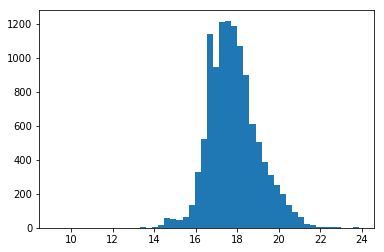

In [15]:
# Convert target `totals.transactionRevenue` with log1p
y = np.log1p(df_train['totals.transactionRevenue'].fillna(0))
plt.hist(y[y > 0], bins=50);

In [16]:
# fillna
print('Number of records which are null in the train and test set')
pd.concat([df_train[list(columns)].isnull().sum(0), df_test[list(columns)].isnull().sum(0)], keys=['train', 'test'], axis=1).sort_index()

# fillna with 0
for i in ['totals.bounces', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.page']:
    df_train[i].fillna(0, inplace=True)
    df_test[i].fillna(0, inplace=True)

# fillna with the word "NONE"
for i in ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.keyword', 'trafficSource.referralPath']:
    df_train[i].fillna('NONE', inplace=True)
    df_test[i].fillna('NONE', inplace=True)

# change True, False to 1, 0
df_train['trafficSource.adwordsClickInfo.isVideoAd'].replace({ np.nan: 1, False: 0 }, inplace=True); df_test['trafficSource.adwordsClickInfo.isVideoAd'].replace({ np.nan: 1, False: 0 }, inplace=True)
df_train['trafficSource.isTrueDirect'].replace({ np.nan: 0, True: 1 }, inplace=True); df_test['trafficSource.isTrueDirect'].replace({ np.nan: 0, True: 1 }, inplace=True)
df_train['device.isMobile'].replace({ True: 1, False: 0 }, inplace=True); df_test['device.isMobile'].replace({ True: 1, False: 0 }, inplace=True)

print('Number of records which are null in the train and test set after fillna')
pd.concat([df_train[list(columns)].isnull().sum(0), df_test[list(columns)].isnull().sum(0)], keys=['train', 'test'], axis=1).sum()

Number of records which are null in the train and test set
Number of records which are null in the train and test set after fillna


train    0
test     0
dtype: int64

In [17]:
%%time
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder

def encode_oh(var, threshold = 0.0005, ohe = OneHotEncoder(handle_unknown='ignore')):
    levels = df_train[var].value_counts()
    levels = levels[levels / len(df_train) > 0.0005].index.values.reshape(-1, 1) # need to use the threshold, otherwise the dimensions explode and eat up all the memory
    ohe.fit(levels)
    train = ohe.transform(df_train[var].values.reshape(-1, 1))
    test = ohe.transform(df_test[var].values.reshape(-1, 1))
    feature_names = [var + '__' + i[3:] for i in ohe.get_feature_names()]
    return train, test, feature_names

# LabelBinarizer
# def encode_lb(var, threshold = 0.0001, array = None):
#     lb = LabelEncoder()
#     # var, the var to be encoded    
#     # thresold, default at 0.0001 or 0.01%. Keep columns where at least 0.01% of rows are not 0
#     # array, prodive an array of categories to be fitted
#     lb.fit(array or df_train[var])
#     train = lb.transform(df_train[var])
#     test = lb.transform(df_test[var])
#     columns = [var + '__' + str(i) for i in lb.classes_]
#     columns_to_keep = train.sum(0) / train.sum() > thresold
#     train = train[:, columns_to_keep]
#     test = test[:, columns_to_keep]
#     columns = np.array(columns)[columns_to_keep]    
#     return train, test, columns
    
# predictors

# categorical variables + numeric variables
tmp = [encode_oh(i) for i in [
    'channelGrouping',
    'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent',
    'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source',
]] + [(sparse.csr_matrix(df_train[i].values.reshape(-1, 1)), sparse.csr_matrix(df_test[i].values.reshape(-1, 1)), [i]) for i in [
    'device.isMobile', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'visitNumber', 'visitStartTime.month', 'visitStartTime.week', 'visitStartTime.day', 'visitStartTime.weekday', 'visitStartTime.hour'
]]

X = sparse.hstack([i[0] for i in tmp]).tocsr()
X_test = sparse.hstack([i[1] for i in tmp])
columns = np.concatenate([i[2] for i in tmp])

# # free up memory
%xdel sparse
%xdel encode_oh
%xdel tmp

CPU times: user 16.1 s, sys: 1.13 s, total: 17.3 s
Wall time: 17.3 s


In [18]:
%%time
from sklearn.preprocessing import LabelEncoder
tmp_cats = [
    'channelGrouping',
    'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent',
    'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source',
    'sessionId', 'visitId', 'fullVisitorId', # fullVisitorId could be useful
]
tmp_nums = ['device.isMobile', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'visitNumber', 'visitStartTime', 'visitStartTime.month', 'visitStartTime.week', 'visitStartTime.day', 'visitStartTime.weekday', 'visitStartTime.hour']

# Xl: X using labelEncoder
Xl = df_train[tmp_cats + tmp_nums].copy()
Xl_test = df_test[tmp_cats + tmp_nums].copy()

l = LabelEncoder()
print('Processing:', end=' ')
for i in tmp_cats:
    print(i, end=', ')
    # because labelencoder cannot encode unseen labels
    Xl[i] = l.fit_transform(Xl[i]) + 1 # all existing labels will be +1
    in_index = Xl_test[i].isin(l.classes_) # select rows in test_df where labels have been seen 
    Xl_test.loc[in_index, i] = l.transform(Xl_test[i][in_index]) + 1
    Xl_test.loc[~in_index, i] = 0 # all unseen label will be coded 0
#     l.fit(np.concatenate([Xl[i].values.astype(str), Xl_test[i].values.astype(str)]))
#     Xl[i] = l.transform(Xl[i].values.astype(str))
#     Xl_test[i] = l.transform(Xl_test[i].values.astype(str))

# free up memory
%xdel l
%xdel tmp_cats
%xdel tmp_nums

Processing: channelGrouping, device.browser, device.deviceCategory, device.operatingSystem, geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source, sessionId, visitId, fullVisitorId, CPU times: user 22 s, sys: 1.88 s, total: 23.9 s
Wall time: 24 s


## Saving data
Save these data to be used later

In [21]:
%%time
import pickle

for filename, obj in [
    ('df_train', df_train), ('df_test', df_test),
    ('X', X), ('X_test', X_test),
    ('Xl', Xl), ('Xl_test', Xl_test),
]:
    with open(filename + '.pickle', 'wb') as handle: pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 4.62 s, sys: 3.52 s, total: 8.14 s
Wall time: 14.9 s
